In [3]:
# Connection
import mysql.connector
import sys

# Utility
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Preprocessing
# import string
from nltk import *
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #pour pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn

# Modelling
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D , Activation, InputLayer, LSTM
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (classification_report, confusion_matrix, 
                            f1_score,accuracy_score, precision_score, 
                             recall_score, roc_auc_score) 

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
def connect():
    try:
        cnx = mysql.connector.connect(host="localhost",user="root",password="root",auth_plugin='mysql_native_password',database="sentiment_analysis")
    except mysql.connector.Error as err:
        cnx = False
        print(err)
        sys.exit(1)
    finally:
        return cnx

In [5]:
conn = connect()
conn
cursor = conn.cursor()

In [6]:
def create_dataframe():
    cursor.execute("""  SELECT *
                    FROM clothing_reviews; """)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows,columns=['Index','Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'])
    df = df.set_index('Index')
    df = df.replace('',np.nan,regex = True)
    return df

In [7]:
df_ori = create_dataframe()

# Cleaning

In [8]:
#Suppression de 845 données car il nous faut absolument TOUTES les Review Text
df_ori.dropna(subset=['Review Text'], inplace=True)
# df_ori.isna().sum()

In [9]:
df = df_ori[["Review Text","Recommended IND"]]

In [10]:
stop_words = stopwords.words('english')

In [11]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

In [12]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.replace("'", "").lower()) 
        
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. Lemmatize
    POS_tagging = pos_tag(tokens_without_sw)
    wordnet_pos_tag=[]
    wordnet_pos_tag = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in POS_tagging]
    wnl = WordNetLemmatizer()
    lemma = [wnl.lemmatize(word, tag) for word, tag in wordnet_pos_tag]
    
    return " ".join(lemma)

In [13]:
df['Document'] = df['Review Text'].apply(cleaning)
df

<ipython-input-13-a330432e54a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Document'] = df['Review Text'].apply(cleaning)


,Review Text,Recommended IND,Document
Index,,,
1,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
2,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happen find store im gl...
3,I had such high hopes for this dress and reall...,0,high hope dress really wanted work initially o...
4,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ev...
5,This shirt is very flattering to all due to th...,1,shirt flatter due adjustable front tie perfect...
...,...,...,...
23482,I was very happy to snag this dress at such a ...,1,happy snag dress great price easy slip flatter...
23483,"It reminds me of maternity clothes. soft, stre...",1,reminds maternity clothes soft stretchy shiny ...
23484,"This fit well, but the top was very see throug...",0,fit well top see never would work im glad able...


In [14]:
# df.to_csv('./datasets/df_cleaned.csv')

# Modèle DL

In [15]:
X = df["Document"].values
y = df["Recommended IND"].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 101)

In [18]:
#Parametres

TOKENIZER_NUM_WORDS = None #None by default
SEQUENCE_LENGTH = 300 #None by default

# model
EPOCHS = 30
BATCH_SIZE = 1024

In [100]:
def LSTM_Model(train_x, train_y, neurons=10, optimizer='adam', vocab_size=vocab_size, input_shape=input_shape):
    lstm_model = Sequential()
    lstm_model.add(InputLayer(input_shape=(input_shape,)))
    lstm_model.add(Embedding(vocab_size,SEQUENCE_LENGTH,input_length=input_shape))
    lstm_model.add(LSTM(neurons, return_sequences=True)) #return sequences ?
    lstm_model.add(Flatten())
    lstm_model.add(Dense(1, activation="sigmoid"))
    #compile the model
    lstm_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
    return lstm_model

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, restore_best_weights=True)

# Test RandomUnderSampling

In [24]:
from imblearn.under_sampling import RandomUnderSampler

In [35]:
rus = RandomUnderSampler(random_state=42,sampling_strategy=0.6)
X_rus, y_rus = rus.fit_resample(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


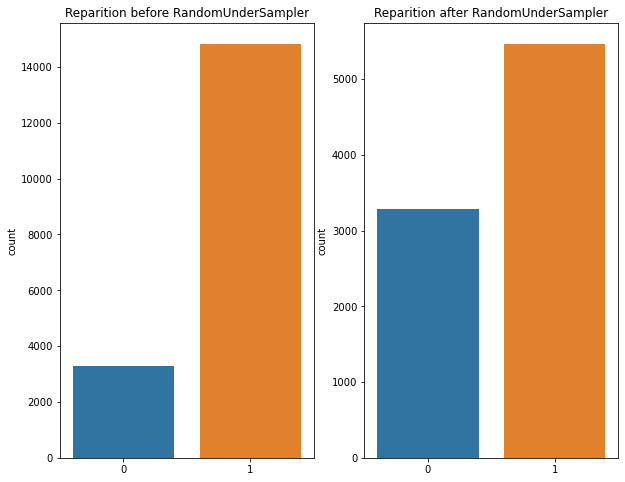

In [36]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Reparition before RandomUnderSampler')
plt.subplot(1, 2, 2)
sns.countplot(y_rus)
plt.title('Reparition after RandomUnderSampler')
plt.show()

AVEC MODELE

In [54]:
#Reshape en tableau pour passer dans le tokenizer
X_train_rus = X_rus.reshape(-1)
y_train_rus = y_rus.reshape(-1)

In [50]:
%%time

#Tokenize

tokenizer = Tokenizer(num_words=TOKENIZER_NUM_WORDS)
tokenizer.fit_on_texts(X_train_rus)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 7532
Wall time: 436 ms


In [52]:
%%time
X_train_padseq_rus = pad_sequences(tokenizer.texts_to_sequences(X_train_rus), maxlen=SEQUENCE_LENGTH)
X_test_padseq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

input_shape = X_train_padseq_rus.shape[1]

Wall time: 824 ms


In [60]:
lstm_model = LSTM_Model(train_x=X_train_padseq_rus,train_y=y_train_rus,vocab_size=vocab_size, input_shape=input_shape)

In [84]:
%%time
history = lstm_model.fit(X_train_padseq_rus, y_train_rus,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    callbacks=[early_stopping])

Epoch 1/30
6/6 [==============================] - 14s 2s/step - loss: 0.1019 - accuracy: 0.9683 - val_loss: 0.7206 - val_accuracy: 0.7802
Epoch 2/30
6/6 [==============================] - 13s 2s/step - loss: 0.0910 - accuracy: 0.9722 - val_loss: 0.7687 - val_accuracy: 0.7775
Epoch 3/30
6/6 [==============================] - 13s 2s/step - loss: 0.0808 - accuracy: 0.9768 - val_loss: 0.7578 - val_accuracy: 0.7909
Epoch 4/30
6/6 [==============================] - 13s 2s/step - loss: 0.0729 - accuracy: 0.9811 - val_loss: 0.8882 - val_accuracy: 0.7653
Epoch 5/30
6/6 [==============================] - 13s 2s/step - loss: 0.0648 - accuracy: 0.9843 - val_loss: 0.9212 - val_accuracy: 0.7714
Epoch 6/30
6/6 [==============================] - 13s 2s/step - loss: 0.0592 - accuracy: 0.9860 - val_loss: 0.8880 - val_accuracy: 0.7863
Wall time: 1min 19s


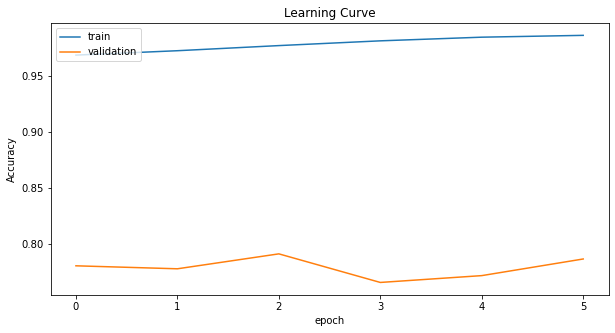

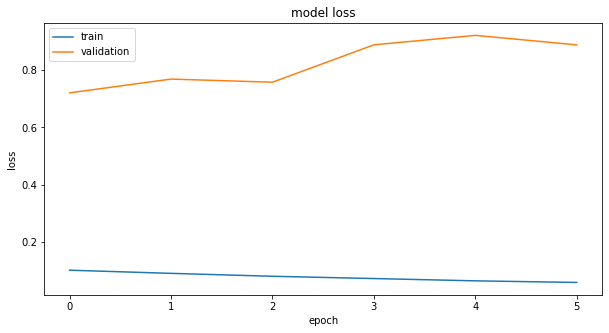

In [85]:
plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Prediction

In [86]:
pred_train_lstm_rus = lstm_model.predict(X_train_padseq_rus)
pred_test_lstm = lstm_model.predict(X_test_padseq)

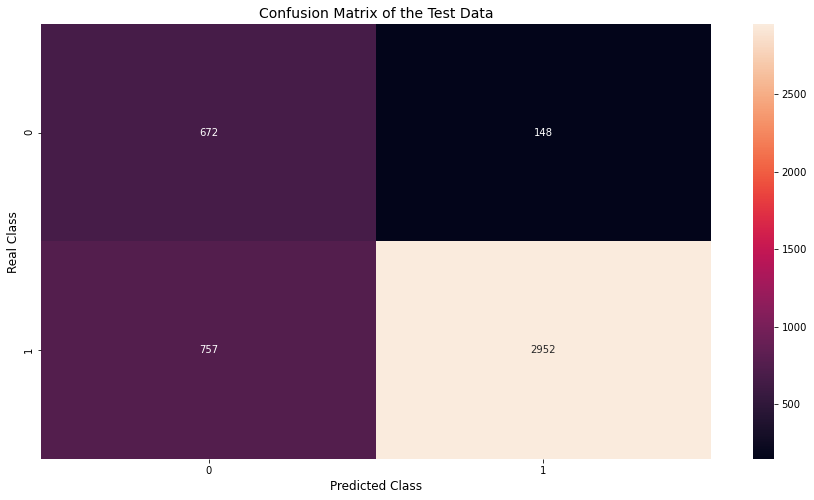

In [87]:
for i, x in enumerate(pred_test_lstm):
    if 0 <= x < 0.49:
        pred_test_lstm[i] = 0
    else:
        pred_test_lstm[i] = 1

for i, x in enumerate(pred_train_lstm_rus):
    if 0 <= x < 0.49:
        pred_train_lstm_rus[i] = 0
    else:
        pred_train_lstm_rus[i] = 1

conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

In [88]:
print(classification_report(y_test, pred_test_lstm))

              precision    recall  f1-score   support

           0       0.47      0.82      0.60       820
           1       0.95      0.80      0.87      3709

    accuracy                           0.80      4529
   macro avg       0.71      0.81      0.73      4529
weighted avg       0.86      0.80      0.82      4529



# SMOTE

In [89]:
from imblearn.over_sampling import SMOTE

In [92]:
%%time

#Tokenize

tokenizer2 = Tokenizer(num_words=TOKENIZER_NUM_WORDS)
tokenizer2.fit_on_texts(X_train)

vocab_size2 = len(tokenizer2.word_index) + 1
print("Total words", vocab_size2)

Total words 10207
Wall time: 1 s


In [93]:
%%time
X_train_padseq2 = pad_sequences(tokenizer2.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
X_test_padseq2 = pad_sequences(tokenizer2.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

input_shape2 = X_train_padseq2.shape[1]

Wall time: 1.05 s


In [95]:
# smt = SMOTE(sampling_strategy=0.2)
smt = SMOTE(sampling_strategy="minority")
X_smote, y_smote = smt.fit_resample(X_train_padseq2, y_train)

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


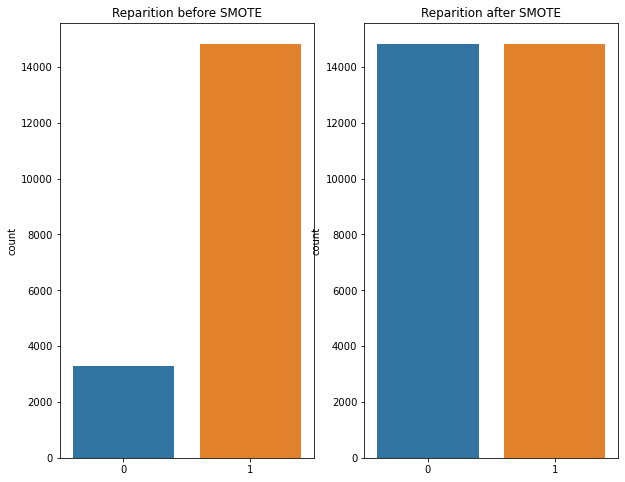

In [96]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Reparition before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Reparition after SMOTE')
plt.show()

AVEC MODELE

In [101]:
lstm_model2 = LSTM_Model(train_x=X_smote,train_y=y_smote, vocab_size=vocab_size2, input_shape=input_shape2)

In [125]:
#Parametres

# model
EPOCHS = 30


In [126]:
%%time
history2 = lstm_model2.fit(X_smote, y_smote,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    callbacks=[early_stopping])

Epoch 1/30
21/21 [==============================] - 44s 2s/step - loss: 0.0860 - accuracy: 0.9689 - val_loss: 1.6723 - val_accuracy: 0.6074
Epoch 2/30
21/21 [==============================] - 43s 2s/step - loss: 0.0784 - accuracy: 0.9718 - val_loss: 1.8946 - val_accuracy: 0.5922
Epoch 3/30
21/21 [==============================] - 44s 2s/step - loss: 0.0694 - accuracy: 0.9750 - val_loss: 1.6069 - val_accuracy: 0.6343
Epoch 4/30
21/21 [==============================] - 44s 2s/step - loss: 0.0676 - accuracy: 0.9760 - val_loss: 2.2919 - val_accuracy: 0.5443
Epoch 5/30
21/21 [==============================] - 44s 2s/step - loss: 0.0690 - accuracy: 0.9748 - val_loss: 1.6923 - val_accuracy: 0.6443
Epoch 6/30
21/21 [==============================] - 44s 2s/step - loss: 0.0643 - accuracy: 0.9772 - val_loss: 2.2233 - val_accuracy: 0.5709
Epoch 7/30
21/21 [==============================] - 46s 2s/step - loss: 0.0562 - accuracy: 0.9801 - val_loss: 2.1749 - val_accuracy: 0.5850
Epoch 8/30
21/21 [==

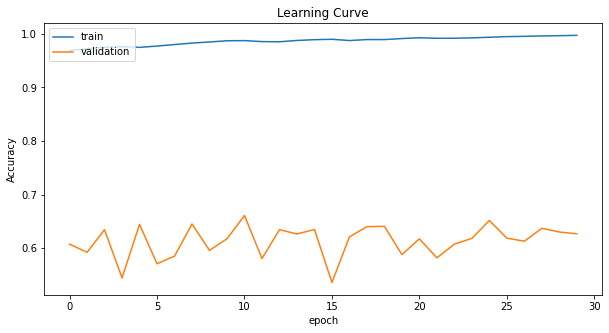

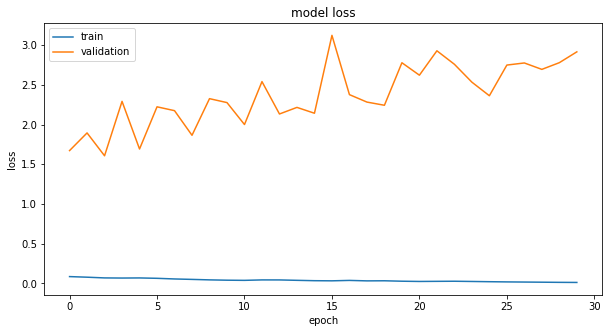

In [127]:
plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Prediction

In [128]:
pred_train_lstm2 = lstm_model2.predict(X_smote)
pred_test_lstm2 = lstm_model2.predict(X_test_padseq2)

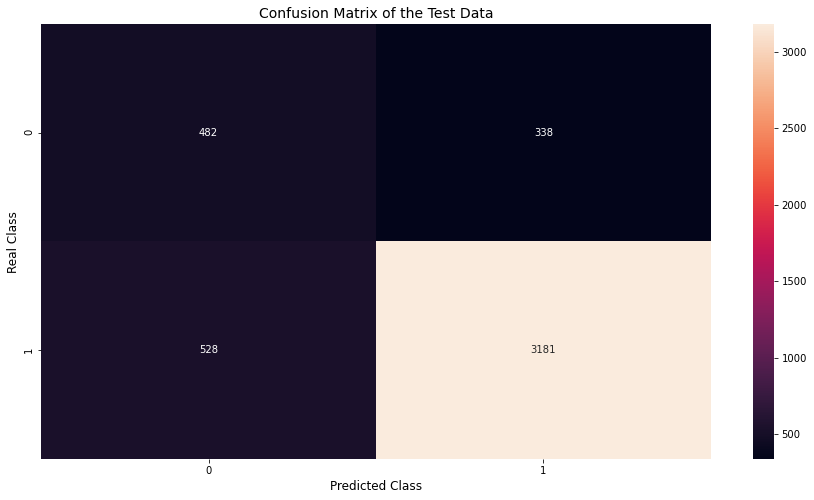

In [129]:
for i, x in enumerate(pred_test_lstm2):
    if 0 <= x < 0.49:
        pred_test_lstm2[i] = 0
    else:
        pred_test_lstm2[i] = 1

for i, x in enumerate(pred_train_lstm2):
    if 0 <= x < 0.49:
        pred_train_lstm2[i] = 0
    else:
        pred_train_lstm2[i] = 1

conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm2)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

In [130]:
print(classification_report(y_test, pred_test_lstm2))

              precision    recall  f1-score   support

           0       0.48      0.59      0.53       820
           1       0.90      0.86      0.88      3709

    accuracy                           0.81      4529
   macro avg       0.69      0.72      0.70      4529
weighted avg       0.83      0.81      0.82      4529

